# Machine Learning Engineer Capstone Project
## Starbucks Challenge
### by Mark-Danney Oonk

---

This notebook describes:
- The project definition with an overview of the project, the problem statement and metrics to be used;
- Data analysis and preprocessing

The code in this notebook results in:
- data/baselineData.csv with preprocessed baseline data to be used in training a baseline model;
- data/history.csv with preprocessed data to be used in training the actual model;
- model/scaler.save with the fitted scaler so it can be used when processing individual recommendatations;
- ./model/SCALED_COLS with the ordered names of scaled columns so scaling information may be retrieved.

## Definition

### Project Overview

Starbucks wants to target users of their app with personalized messages, giving its customers the best possible offers on the right channels in order to stimulate their spending behavior.

To this end, Starbucks ran a pilot with several different propositions and monitoring whether, and if so when, the offer was viewed. Any consequent spending behavior of the pilot customers was logged. Using this data we will train a machine learning model that can be exposed in an endpoint in order to provide the app, e-mail or online channels with the best offers for a given customer in real-time.

Starbucks has provided us with three related datasets:
- Profiles, containing information about customers such as age, gender, account age and income;
- a Portfolio of available offers describing their difficulty to attain the offer (required spending before a Buy one, Get one free (BOGO) kicks in for instance), offer duration and the amount rewarded;
- Transcripts of monetary transactions as well as the dates offers were sent, viewed and completed by customers.

### Problem Statement

The problem is very similar to a so-called collaborative filtering personalization, where customers are recommended products based on their earlier interests similar to other customers that then recommended other products. Only in this case, the recommended products are new offers and recommendations made by others are them actually spending in order to complete the order.

Collaborative filtering personalization has in the past been successfully implemented using neural networks, so this will be the route taken for the problem at hand. The output of the model will be an ordered list of offer/channel combinations, along with and ordered by the predicted customer spending.

### Metrics

Model success will be measured by a combination of Log Loss, as this metric works well at measuring multi-class classification quality by penalizing erroneous classification based on uncertainty of the predictions, and F-1 score to measure the precision and recall. [[3]](#3)

Log loss:

![formula](https://latex.codecogs.com/svg.image?%5Cfrac%7B-1%7D%7BN%7D%5Csum_%7Bi=1%7D%5E%7BN%7D%5Csum_%7Bj=1%7D%5E%7BM%7Dy_%7Bij%7D%5Ctimes%20%5Clog(p_%7Bij%7D))

where:
- y_ij indicates whether sample i belongs to class j or not
- p_ij indicates the probability of sample i belonging to class j

In the context of the problem at hand, it pushes the model towards the right money spent prediction per offer/channel.

F-1:

![formula](https://latex.codecogs.com/svg.image?%5Cfrac%7Btp%7D%7Btp%20+%20%5Cfrac%7B1%7D%7B2%7D(fp%20+%20fn)%7D)

where:
- tp, fp are the number of true resp. false positives
- tn, fn are the number of true resp. false negatives

Positives and negatives will be measured by the outcome of the neuron, >=0.5 is positive, <0.5 is negative.

## Analysis

### Data Exploration

In [207]:
# imports

import joblib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandasql as psql
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer, MinMaxScaler
from scipy import stats
from typing import Tuple

In [208]:
# read in the data files

portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Portfolio

In [209]:
portfolio.head()

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [210]:
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

<AxesSubplot:>

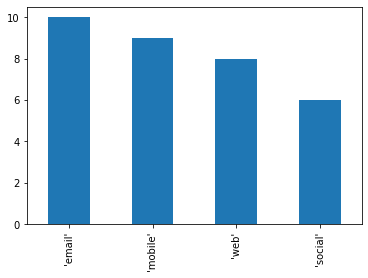

In [211]:
portfolio.channels.apply(str).replace(['\[', '\]'], '', regex=True).str.split(', ', expand=True).stack().value_counts().plot(kind='bar')

The portfolio dataset contains offers sent during 30-day test period (10 offers x 6 fields):

- reward: (numeric) money awarded for the amount spent
- channels: (list) web, email, mobile, social
- difficulty: (numeric) money required to be spent to receive reward
- duration: (numeric) time for offer to be open, in days
- offer_type: (string) bogo, discount, informational
- id: (string/hash)

It contains only properly filled records. Required preprocessing will be:

- One-hot encoding of Channels and OfferType
- Min-Max normalization of Reward, Difficulty and Duration to 0..1 values

### Profile

In [212]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


Age mean: 54.39352445193929, stdev: 17.383119058990765
female/male distribution: 0.72


<AxesSubplot:title={'center':'Membership'}>

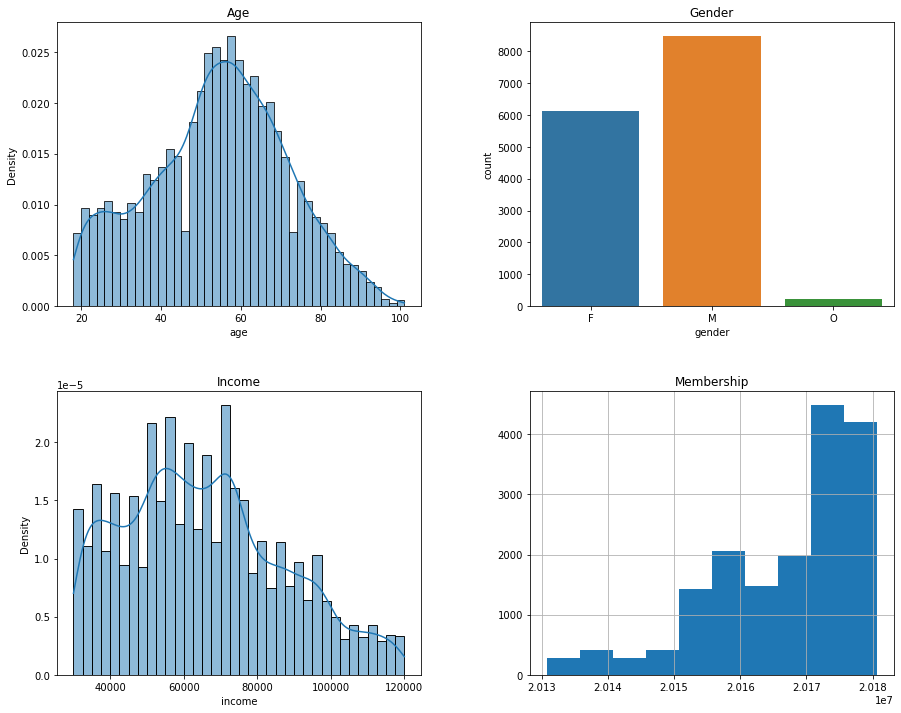

In [214]:
plt.subplots(2, 2, figsize=(15, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.subplot(221)
plt.title('Age')
data = profile[profile.age != 118].age
sns.histplot(data, kde=True, stat="density")
print('Age mean: {}, stdev: {}'.format(np.mean(data), np.std(data)))

plt.subplot(222)
plt.title('Gender')
sns.countplot(x='gender', data=profile)
print('female/male distribution: {0:.2f}'.format(profile[profile.gender == 'F'].gender.count() / profile[profile.gender == 'M'].gender.count()))

plt.subplot(223)
plt.title('Income')
sns.histplot(profile.income, kde=True, stat="density")

plt.subplot(224)
plt.title('Membership')
profile['became_member_on'].hist()

Observations:
- The participant age is fairly normally-distributed, with a skew to the 18-35 bracket as may be expected for app usage. Income however is quite irregular.
- Most accounts are presumed fairly new at the time this data was gathered.

From here on out, membership age will be calculated in distance from the last created account, so not all accounts start as 4 years old making the data unusable for current accounts.

<AxesSubplot:title={'center':'Income by age'}, xlabel='age', ylabel='income'>

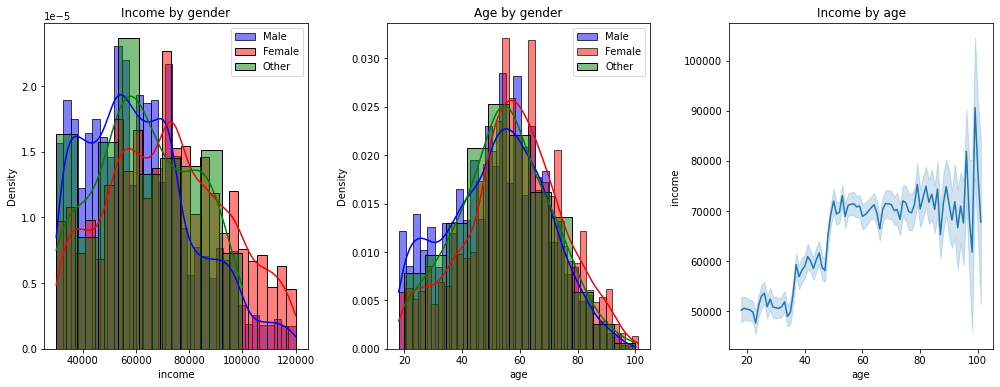

In [164]:
plt.subplots(1, 3, figsize=(17, 6))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.subplot(131)
plt.title('Income by gender')
sns.histplot(profile[profile.gender=='M'].income, label='Male', kde=True, stat="density", color='b')
sns.histplot(profile[profile.gender=='F'].income, label='Female', kde=True, stat="density", color='r')
sns.histplot(profile[profile.gender=='O'].income, label='Other', kde=True, stat="density", color='g')
plt.legend()

plt.subplot(132)
plt.title('Age by gender')
sns.histplot(profile[profile.gender=='M'].age, label='Male', kde=True, stat="density", color='b')
sns.histplot(profile[profile.gender=='F'].age, label='Female', kde=True, stat="density", color='r')
sns.histplot(profile[profile.gender=='O'].age, label='Other', kde=True, stat="density", color='g')
plt.legend()

plt.subplot(133)
plt.title('Income by age')
sns.lineplot(x=profile[profile.age < 118].age, y=profile[profile.income.notna()].income)

In [165]:
profile.loc[profile['gender'].isnull()].describe()

,age,became_member_on,income
count,2175.0,2.175000e+03,0.0
mean,118.0,2.016804e+07,NaN
std,0.0,1.009105e+04,NaN
min,118.0,2.013080e+07,NaN
25%,118.0,2.016070e+07,NaN
50%,118.0,2.017073e+07,NaN
75%,118.0,2.017123e+07,NaN
max,118.0,2.018073e+07,NaN


When gender is not filled, so are income and age.

In [166]:
profileNulls = profile.loc[(profile.gender.isnull()) & (profile.income.isnull()) & (profile.age == 118)]
profileCleaned = profile.loc[(profile.gender.notnull()) & (profile.income.notnull()) & (profile.age != 118)]

print('Percentage of invalid profiles: %.2f' % (profileNulls.shape[0] / profile.shape[0] * 100))
print('Remaining profiles: %d' % profileCleaned.shape[0])

Percentage of invalid profiles: 12.79
Remaining profiles: 14825


Profiles contain the rewards program users (17000 users x 5 fields)

- gender: (categorical) M, F, O, or null
- age: (numeric) missing value encoded as 118
- id: (string/hash)
- became_member_on: (date) format YYYYMMDD
- income: (numeric)

Almost 13% of the profiles aren't filled in correctly. Interestingly though, all of the profiles that contained missing values were missing all three Gender, Age and Income. This may indicate that the data isn't simply missing but may actually be purposefully not filled in by the user. This group will be analyzed as its own demographic to see if we can identify recurring spending behavior.

Required preprocessing will be:

- One-hot encoding of Gender
- Translating BecameMemberOn to AccountAge in days
- Filling missing Age and Income fields with mean values for that column
- Min-Max normalization of Age, Income and AccountAge to 0..1 values

### Transcript

In [167]:
print(transcript.shape[0])
transcript.head()

306534


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


Since the Value column contains JSON information, we'll unpack that into separate columns.

In [168]:
df1 = pd.DataFrame(transcript['value'].values.tolist())
df1.columns = df1.columns
df1.offer_id.fillna(df1['offer id'], inplace=True) # Some events call it offer_id, some offer id. So, merge those together
del df1['offer id']

transcriptExpanded = pd.concat([transcript, df1], axis=1)
transcriptExpanded = transcriptExpanded.drop(columns='value')

transcriptExpanded.amount = pd.to_numeric(transcriptExpanded.amount, downcast='float')
transcriptExpanded.reward = pd.to_numeric(transcriptExpanded.reward, downcast='float')
transcriptExpanded.time = pd.to_numeric(transcriptExpanded.time, downcast='integer')
transcriptExpanded = transcriptExpanded.astype({'offer_id':str, 'person': str, 'event': str})

transcriptExpanded.head()

,person,event,time,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


In [169]:
transcriptExpanded.isnull().sum()

person           0
event            0
time             0
amount      167581
offer_id         0
reward      272955
dtype: int64

In [170]:
transcriptExpanded.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

The nulls are as expected; only transactions have amounts and only offer completed events have rewards. For the rest the data is clean.

In [171]:
transcriptEmptyProfiles = transcriptExpanded.loc[transcriptExpanded.person.isin(profileNulls.id)]
transcriptCleaned = transcriptExpanded.loc[transcriptExpanded.person.isin(profileCleaned.id)]

print('Percentage of transcripts belonging to empty profiles: %.2f' % (transcriptEmptyProfiles.shape[0] / transcriptExpanded.shape[0] * 100))
print('Remaining transcripts: %d' % transcriptCleaned.shape[0])

Percentage of transcripts belonging to empty profiles: 11.02
Remaining transcripts: 272762


Transcripts contain event logs (306648 events x 4 fields)

- person: (string/hash)
- event: (string) offer received, offer viewed, transaction, offer completed
- value: (dictionary) different values depending on event type
  - offer id: (string/hash) not associated with any "transaction"
  - amount: (numeric) money spent in "transaction"
  - reward: (numeric) money gained from "offer completed"
- time: (numeric) hours after start of test

Although all events are filled properly, about 11% may need to be treated differently as they are related to the unfilled profiles.

Starbucks has warned not to include completed but not viewed offers; the customer may have received its reward but wasn't influenced by it because they didn't know about the offer contents.

Required pre-processing will be:

- Identifying each offering per person as some people have received the same offer 5 times
- Merging events into complete histories per received offer:
  - Hours between offer received and offer viewed
  - Hours between offer viewed and offer completed
  - Transaction total between offer viewed and offer completed
- Remove histories where offer has not been viewed
- Merge in Person and Portfolio features, delete the id's
- Split up histories for offers that were shown on multiple channels, so each record contains one offer, one channel and its total money spent
- One-hot encode channels
- Min-Max normalize the transaction total and time features

## Preprocessing

During data exploration, some preprocessing has already been done. However, to make the preprocessing repeatable for new data all steps will be replicated in methods here.

### Portfolio

- Encoding of Channels and OfferType
- Min-Max normalization of Reward, Difficulty and Duration to 0..1 values will happen at the end to create a completely trained scaler for use on future data

In [172]:
def EncodeChannels(df: pd.DataFrame, column: str):
    result = pd.DataFrame(df)
    mlb = MultiLabelBinarizer()
    return result.join(pd.DataFrame(mlb.fit_transform(result.pop(column)), index=result.index, columns=mlb.classes_).add_prefix(column + '_'))

In [173]:
portfolioChannelEncoded = EncodeChannels(portfolio, 'channels')
portfolioChannelEncoded.head()

,reward,difficulty,duration,offer_type,id,channels_email,channels_mobile,channels_social,channels_web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1


In [174]:
def Encoding(df: pd.DataFrame, columns: list):
    result = pd.DataFrame(df)
    ohe = OneHotEncoder(handle_unknown='ignore')
    encoded = pd.DataFrame(ohe.fit_transform(result[columns]).toarray(), index=result.index, columns=ohe.get_feature_names_out(columns))
    return result.drop(columns=columns).join(encoded)

In [175]:
portfolioEncoded = Encoding(portfolioChannelEncoded, ['offer_type'])
portfolioEncoded.head()


,reward,difficulty,duration,id,channels_email,channels_mobile,channels_social,channels_web,offer_type_bogo,offer_type_discount,offer_type_informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1.0,0.0,0.0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1.0,0.0,0.0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0.0,0.0,1.0
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1.0,0.0,0.0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0.0,1.0,0.0


In [176]:
def Scaling(df: pd.DataFrame, columns: list) -> Tuple[pd.DataFrame, MinMaxScaler]:
    result = pd.DataFrame(df)
    scaler = MinMaxScaler()
    result[columns] = pd.DataFrame(scaler.fit_transform(result[columns]), index=result.index, columns=columns)
    return (result, scaler)

In [177]:
portfolioScaledEncoded, scaler = Scaling(portfolioEncoded, ['reward', 'difficulty']) # don't scale duration, we need the raw value for the transaction history compilation
portfolioScaledEncoded.head()

,reward,difficulty,duration,id,channels_email,channels_mobile,channels_social,channels_web,offer_type_bogo,offer_type_discount,offer_type_informational
0,1.0,0.50,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1.0,0.0,0.0
1,1.0,0.50,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1.0,0.0,0.0
2,0.0,0.00,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0.0,0.0,1.0
3,0.5,0.25,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1.0,0.0,0.0
4,0.5,1.00,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0.0,1.0,0.0


In [178]:
def PreprocessPortfolio(portfolio):
    portfolioChannelEncoded = EncodeChannels(portfolio, 'channels')
    portfolioEncoded = Encoding(portfolioChannelEncoded, ['offer_type'])
    return portfolioEncoded

In [179]:
portfolioEncoded = PreprocessPortfolio(portfolio)
portfolioEncoded.head()

,reward,difficulty,duration,id,channels_email,channels_mobile,channels_social,channels_web,offer_type_bogo,offer_type_discount,offer_type_informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1.0,0.0,0.0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1.0,0.0,0.0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0.0,0.0,1.0
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1.0,0.0,0.0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0.0,1.0,0.0


### Profile

- One-hot encoding of Gender
- Translating BecameMemberOn to AccountAge in days counted from newest account in the dataset
- Filling missing Age and Income fields with mean values for that column
- Min-Max normalization of Age, Income and AccountAge to 0..1 values will be done at the end of preprocessing in order to get a fully fitted scaler for future use

In [180]:
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [181]:
def PreprocessProfile(df: pd.DataFrame, ignoreNotFilled: bool = False):
    profile = pd.DataFrame(df)
    if not ignoreNotFilled:
        profile.gender = profile.gender.fillna('U')
        profileEncoded = Encoding(profile, ['gender'])
        profileEncoded.income = profileEncoded.income.fillna(profileEncoded.income.mean())
        ageNand = profileEncoded.age.replace(118, np.nan)
        profileEncoded.age = ageNand.fillna(ageNand.mean())
    else:
        profile = profile.dropna(subset=['gender', 'income'], axis=0)        
        profileEncoded = Encoding(profile, ['gender'])
        profileEncoded['gender_U'] = 0.0
    profileEncoded.became_member_on = pd.to_datetime(profileEncoded.became_member_on, format='%Y%m%d', exact=True)
    profileEncoded['account_age'] = (profileEncoded.became_member_on.max() - profileEncoded.became_member_on).dt.days
    return profileEncoded.drop(columns='became_member_on')

In [182]:
profileEncoded = PreprocessProfile(profile)
profileEncoded.describe()

,age,income,gender_F,gender_M,gender_O,gender_U,account_age
count,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000
mean,54.393524,65404.991568,0.360529,0.499059,0.012471,0.127941,517.449882
std,16.233545,20169.288288,0.480168,0.500014,0.110977,0.334034,411.223904
min,18.000000,30000.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,45.000000,51000.000000,0.000000,0.000000,0.000000,0.000000,208.000000
50%,54.393524,65404.991568,0.000000,0.000000,0.000000,0.000000,358.000000
75%,65.000000,76000.000000,1.000000,1.000000,0.000000,0.000000,791.000000
max,101.000000,120000.000000,1.000000,1.000000,1.000000,1.000000,1823.000000


In [183]:
profileEncodedWithoutUnfilled = PreprocessProfile(profile, True)
profileEncodedWithoutUnfilled.describe()

,age,income,gender_F,gender_M,gender_O,gender_U,account_age
count,14825.000000,14825.000000,14825.000000,14825.000000,14825.000000,14825.0,14825.000000
mean,54.393524,65404.991568,0.413423,0.572277,0.014300,0.0,522.478988
std,17.383705,21598.299410,0.492464,0.494765,0.118729,0.0,419.205158
min,18.000000,30000.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,42.000000,49000.000000,0.000000,0.000000,0.000000,0.0,208.000000
50%,55.000000,64000.000000,0.000000,1.000000,0.000000,0.0,358.000000
75%,66.000000,80000.000000,1.000000,1.000000,0.000000,0.0,797.000000
max,101.000000,120000.000000,1.000000,1.000000,1.000000,0.0,1823.000000


### Transcript

- Expand JSON column
- Merging events into complete histories per received offer with transaction totals between offer viewed and offer completed (or before the time limit has exceeded for informationals)
- Merge in Person and Portfolio features, delete the id's
- Min-Max normalize all relevant features

In [184]:
def ExpandTranscriptValues(df: pd.DataFrame) -> pd.DataFrame:
    transcript = pd.DataFrame(df)
    df1 = pd.DataFrame(transcript['value'].values.tolist())
    df1.columns = df1.columns
    df1.offer_id.fillna(df1['offer id'], inplace=True) # Some events call it offer_id, some offer id. So, merge those together
    del df1['offer id']

    transcriptExpanded = pd.concat([transcript, df1], axis=1)
    del transcriptExpanded['value']

    transcriptExpanded.amount = pd.to_numeric(transcriptExpanded.amount, downcast='float')
    transcriptExpanded.time = pd.to_numeric(transcriptExpanded.time, downcast='integer')
    return transcriptExpanded.astype({'offer_id':str, 'person': str, 'event': str})

In [185]:
transcriptExpanded = ExpandTranscriptValues(transcript)
display(transcriptExpanded.head())
display(transcriptExpanded.describe())

,person,event,time,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN


,time,amount,reward
count,306534.000000,138953.000000,33579.000000
mean,366.382940,12.777309,4.904137
std,200.326314,30.249716,2.886647
min,0.000000,0.050000,2.000000
25%,186.000000,2.780000,2.000000
50%,408.000000,8.890000,5.000000
75%,528.000000,18.070000,5.000000
max,714.000000,1062.280029,10.000000


In [186]:
def MergeOfferInformation(transcript: pd.DataFrame, portfolio: pd.DataFrame) -> pd.DataFrame:
    pf = pd.DataFrame(portfolio)
    pf.duration = pf.duration * 24
    result = pd.merge(transcript, pf, left_on='offer_id', right_on='id', how='left')
    del result['id']
    return result

In [187]:
MergeOfferInformation(transcriptExpanded, Encoding(portfolioChannelEncoded, ['offer_type']))

,person,event,time,amount,offer_id,reward_x,reward_y,difficulty,duration,channels_email,channels_mobile,channels_social,channels_web,offer_type_bogo,offer_type_discount,offer_type_informational
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,5.0,5.0,168.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,5.0,20.0,240.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,2.0,10.0,168.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,2.0,10.0,240.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,10.0,10.0,120.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,714,1.59,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,714,9.53,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306531,a00058cf10334a308c68e7631c529907,transaction,714,3.61,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,714,3.53,nan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [188]:
def MergePersonInformation(journeys: pd.DataFrame, profile: pd.DataFrame) -> pd.DataFrame:
    result = pd.merge(journeys, profile, left_on='person', right_on='id', how='inner')
    del result['person']
    del result['id']
    return result

In [189]:
MergePersonInformation(transcriptExpanded, profileEncoded)

,event,time,amount,offer_id,reward,age,income,gender_F,gender_M,gender_O,gender_U,account_age
0,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75.000000,100000.000000,1.0,0.0,0.0,0.0,443
1,offer viewed,6,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,75.000000,100000.000000,1.0,0.0,0.0,0.0,443
2,transaction,132,19.889999,nan,NaN,75.000000,100000.000000,1.0,0.0,0.0,0.0,443
3,offer completed,132,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,75.000000,100000.000000,1.0,0.0,0.0,0.0,443
4,transaction,144,17.780001,nan,NaN,75.000000,100000.000000,1.0,0.0,0.0,0.0,443
...,...,...,...,...,...,...,...,...,...,...,...,...
306529,offer received,576,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,54.393524,65404.991568,0.0,0.0,0.0,1.0,303
306530,offer viewed,594,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,54.393524,65404.991568,0.0,0.0,0.0,1.0,303
306531,offer received,576,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,58.000000,78000.000000,1.0,0.0,0.0,0.0,644
306532,offer viewed,576,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,58.000000,78000.000000,1.0,0.0,0.0,0.0,644


In [190]:
def GetSuccesses(transcriptExpanded: pd.DataFrame, portfolioEncoded: pd.DataFrame) -> pd.DataFrame: # Determines whether an offer was successful; received, viewed and completed. Or viewed within duration in case of informationals.
    
    person_events: pd.DataFrame = transcriptExpanded[transcriptExpanded.offer_id != 'nan'].groupby(['person','offer_id','event'])['time'].count().unstack()
    
    person_events.reset_index(level=[0,1],inplace = True)

    person_events = MergeOfferInformation(person_events, portfolioEncoded)

    # informationals don't have completed events, so we'll complete them here so they can be used in spending calculation. Since we're only counting completed AND viewed, this is fine for informationals.
    person_events.loc[(person_events.offer_type_informational) == 1, 'offer completed'] = 1

    #Replace nan values with 0; these are person/offer combinations that didn't have certain events
    person_events.fillna(0, inplace = True)
    
    # Determine which offers are successful - both viewed AND completed. If either has 0 occurrences, count them as unsuccessful.
    person_events['successful'] = person_events['offer completed'] * person_events['offer viewed']
    person_events['successful'] = person_events['successful'].apply(lambda x: 1 if x > 0 else 0)
    
    person_events.drop(['offer completed','offer viewed','offer received'], axis=1, inplace=True)
                
    return person_events

In [191]:
successes = GetSuccesses(transcriptExpanded, portfolioEncoded)
display(successes.describe())
display(successes.head())

,reward,difficulty,duration,channels_email,channels_mobile,channels_social,channels_web,offer_type_bogo,offer_type_discount,offer_type_informational,successful
count,63288.000000,63288.000000,63288.000000,63288.0,63288.000000,63288.000000,63288.000000,63288.000000,63288.000000,63288.000000,63288.000000
mean,4.206232,7.711572,156.115662,1.0,0.899286,0.599529,0.799425,0.400092,0.400013,0.199896,0.533577
std,3.402914,5.541480,52.885554,0.0,0.300952,0.489998,0.400434,0.489921,0.489904,0.399925,0.498875
min,0.000000,0.000000,72.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,5.000000,120.000000,1.0,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
50%,5.000000,10.000000,168.000000,1.0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000
75%,5.000000,10.000000,168.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,10.000000,20.000000,240.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


,person,offer_id,reward,difficulty,duration,channels_email,channels_mobile,channels_social,channels_web,offer_type_bogo,offer_type_discount,offer_type_informational,successful
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,2,10,168,1,1,0,1,0.0,1.0,0.0,0
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,0,0,96,1,1,0,1,0.0,0.0,1.0,1
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,0,0,72,1,1,1,0,0.0,0.0,1.0,1
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,5,5,120,1,1,1,1,1.0,0.0,0.0,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,2,10,240,1,1,1,1,0.0,1.0,0.0,1


In [192]:
def FindCompletionsForViewedOffers(transcriptExpanded: pd.DataFrame, viewsWithOfferInfo: pd.DataFrame) -> pd.DataFrame:
    completions = pd.merge(viewsWithOfferInfo,
                           transcriptExpanded.loc[transcriptExpanded.event == 'offer completed', ['person', 'offer_id', 'time']],
                           on=['person', 'offer_id'], how='left').rename(columns={'time': 'time_completed'})

    completions.time_completed = completions.apply(lambda row: row.time_received + row.duration if row.offer_type_informational == 1 else row.time_completed, axis=1)
    completions = completions[(completions.time_completed.isna()) | ((completions.time_received <= completions.time_completed) & (completions.time_viewed <= completions.time_completed) & (completions.time_completed <= completions.time_received + completions.duration))]
    completions.drop_duplicates(inplace=True)
    return completions

In [193]:
def FindTransactionsForSuccesses(successes: pd.DataFrame, transcriptExpanded: pd.DataFrame) -> pd.DataFrame: # Gets the amount spent for each person/offer combination
    views = pd.merge(transcriptExpanded.loc[transcriptExpanded['event'] == 'offer received', ['person', 'offer_id', 'time']],
                    transcriptExpanded.loc[transcriptExpanded['event'] == 'offer viewed', ['person', 'offer_id', 'time']],
                    on=['person', 'offer_id'], how='left', suffixes=['_received', '_viewed'])
    views = pd.merge(successes, views, on=['person', 'offer_id'])
    views = views[((views.time_viewed >= views.time_received) & (views.time_viewed <= views.time_received + views.duration))]
    views.drop_duplicates(inplace=True)
    
    completions = FindCompletionsForViewedOffers(transcriptExpanded, views)
    transactions = pd.DataFrame(transcriptExpanded.loc[transcriptExpanded.event == 'transaction', ['person', 'time', 'amount']])

    sql = '''
    select transactions.person, completions.offer_id, sum(transactions.amount) as amount
    from transactions
    inner join completions
    on (
        transactions.person = completions.person
        and (
            transactions.time between completions.time_viewed and completions.time_completed
            or (
                completions.time_completed is null and
                transactions.time between completions.time_viewed and (completions.time_received + completions.duration)
            )
        )
    )
    group by transactions.person, completions.offer_id
    '''

    transactions = psql.sqldf(sql, locals())

    result = pd.merge(successes,
                    transactions,
                    on=['person', 'offer_id'], how='left').fillna(0) # left join and fillna because there are some informationals that are completed, but did not trigger any sales
    del result['offer_id']
    result.loc[(result.successful == 1) & (result.offer_type_informational == 0) & (result.amount == 0), 'successful'] = 0
    return result

In [194]:
successesWithAmount = FindTransactionsForSuccesses(successes, transcriptExpanded)
# remove outliers
successesWithAmount = successesWithAmount[(np.abs(stats.zscore(successesWithAmount.amount)) < 3)]
display(successesWithAmount.describe())

,reward,difficulty,duration,channels_email,channels_mobile,channels_social,channels_web,offer_type_bogo,offer_type_discount,offer_type_informational,successful,amount
count,62832.000000,62832.000000,62832.000000,62832.0,62832.000000,62832.000000,62832.000000,62832.000000,62832.000000,62832.000000,62832.000000,62832.000000
mean,4.208906,7.706901,155.980138,1.0,0.899128,0.598580,0.799211,0.400815,0.398921,0.200264,0.476604,10.225229
std,3.403905,5.545494,52.824989,0.0,0.301162,0.490189,0.400594,0.490067,0.489680,0.400201,0.499456,14.959209
min,0.000000,0.000000,72.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,5.000000,120.000000,1.0,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.000000,7.000000,168.000000,1.0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.260000
75%,5.000000,10.000000,168.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,16.390000
max,10.000000,20.000000,240.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,115.580001


In [195]:
def PreprocessTranscript(transcript: pd.DataFrame, portfolioEncoded: pd.DataFrame, profileEncoded: pd.DataFrame) -> pd.DataFrame:
    transcriptExpanded = ExpandTranscriptValues(transcript)
    successes = GetSuccesses(transcriptExpanded, portfolioEncoded)
    successesWithAmount = FindTransactionsForSuccesses(successes, transcriptExpanded)
    successesWithAmount = successesWithAmount[(np.abs(stats.zscore(successesWithAmount.amount)) < 3)]
    return MergePersonInformation(successesWithAmount, profileEncoded)

In [196]:
successesWithAmount = PreprocessTranscript(transcript, portfolioEncoded, profileEncoded)
display(successesWithAmount.head())
display(successesWithAmount.describe())

,reward,difficulty,duration,channels_email,channels_mobile,channels_social,channels_web,offer_type_bogo,offer_type_discount,offer_type_informational,successful,amount,age,income,gender_F,gender_M,gender_O,gender_U,account_age
0,2,10,4032,1,1,0,1,0.0,1.0,0.0,0,0.000000,33.0,72000.0,0.0,1.0,0.0,0.0,461
1,0,0,2304,1,1,0,1,0.0,0.0,1.0,1,105.440000,33.0,72000.0,0.0,1.0,0.0,0.0,461
2,0,0,1728,1,1,1,0,0.0,0.0,1.0,1,127.599999,33.0,72000.0,0.0,1.0,0.0,0.0,461
3,5,5,2880,1,1,1,1,1.0,0.0,0.0,0,0.000000,33.0,72000.0,0.0,1.0,0.0,0.0,461
4,2,10,5760,1,1,1,1,0.0,1.0,0.0,0,0.000000,33.0,72000.0,0.0,1.0,0.0,0.0,461


,reward,difficulty,duration,channels_email,channels_mobile,channels_social,channels_web,offer_type_bogo,offer_type_discount,offer_type_informational,successful,amount,age,income,gender_F,gender_M,gender_O,gender_U,account_age
count,62530.000000,62530.000000,62530.000000,62530.0,62530.000000,62530.000000,62530.000000,62530.000000,62530.000000,62530.000000,62530.000000,62530.000000,62530.000000,62530.000000,62530.000000,62530.000000,62530.000000,62530.000000,62530.000000
mean,4.217528,7.737086,3752.345690,1.0,0.898577,0.598305,0.800832,0.401103,0.401295,0.197601,0.479146,26.202129,54.326979,65265.927507,0.358404,0.500544,0.012106,0.128946,515.890916
std,3.398621,5.539556,1267.013685,0.0,0.301891,0.490245,0.399378,0.490126,0.490165,0.398193,0.499569,45.277625,16.237971,20169.525541,0.479535,0.500004,0.109361,0.335143,412.154970
min,0.000000,0.000000,1728.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,30000.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,5.000000,2880.000000,1.0,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,45.000000,51000.000000,0.000000,0.000000,0.000000,0.000000,207.000000
50%,5.000000,10.000000,4032.000000,1.0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,11.320000,54.393524,65404.991568,0.000000,1.000000,0.000000,0.000000,356.000000
75%,5.000000,10.000000,4032.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,26.270000,64.000000,76000.000000,1.000000,1.000000,0.000000,0.000000,790.000000
max,10.000000,20.000000,5760.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,319.439991,101.000000,120000.000000,1.000000,1.000000,1.000000,1.000000,1823.000000


In [197]:
SCALED_COLS = ['amount', 'duration', 'reward', 'difficulty', 'age', 'income', 'account_age']

In [198]:
def PreprocessStarbucksData(transcript: pd.DataFrame, portfolio: pd.DataFrame, profile: pd.DataFrame, ignoreEmptyProfiles: bool = False) -> Tuple[pd.DataFrame, MinMaxScaler]:
    successesWithAmount = PreprocessTranscript(transcript, PreprocessPortfolio(portfolio), PreprocessProfile(profile, ignoreEmptyProfiles))
    return Scaling(successesWithAmount, SCALED_COLS)

In [199]:
successesWithAmount, scaler = PreprocessStarbucksData(transcript, portfolio, profile, False)
display(successesWithAmount.head())
display(successesWithAmount.describe())

,reward,difficulty,duration,channels_email,channels_mobile,channels_social,channels_web,offer_type_bogo,offer_type_discount,offer_type_informational,successful,amount,age,income,gender_F,gender_M,gender_O,gender_U,account_age
0,0.2,0.50,0.571429,1,1,0,1,0.0,1.0,0.0,0,0.000000,0.180723,0.466667,0.0,1.0,0.0,0.0,0.25288
1,0.0,0.00,0.142857,1,1,0,1,0.0,0.0,1.0,1,0.074148,0.180723,0.466667,0.0,1.0,0.0,0.0,0.25288
2,0.0,0.00,0.000000,1,1,1,0,0.0,0.0,1.0,1,0.191729,0.180723,0.466667,0.0,1.0,0.0,0.0,0.25288
3,0.5,0.25,0.285714,1,1,1,1,1.0,0.0,0.0,0,0.000000,0.180723,0.466667,0.0,1.0,0.0,0.0,0.25288
4,0.2,0.50,1.000000,1,1,1,1,0.0,1.0,0.0,0,0.000000,0.180723,0.466667,0.0,1.0,0.0,0.0,0.25288


,reward,difficulty,duration,channels_email,channels_mobile,channels_social,channels_web,offer_type_bogo,offer_type_discount,offer_type_informational,successful,amount,age,income,gender_F,gender_M,gender_O,gender_U,account_age
count,62832.000000,62832.000000,62832.000000,62832.0,62832.000000,62832.000000,62832.000000,62832.000000,62832.000000,62832.000000,62832.000000,62832.000000,62832.000000,62832.000000,62832.000000,62832.000000,62832.000000,62832.000000,62832.000000
mean,0.420891,0.385345,0.499882,1.0,0.899128,0.598580,0.799211,0.400815,0.398921,0.200264,0.476604,0.088469,0.437843,0.392544,0.359387,0.500255,0.012096,0.128263,0.283068
std,0.340391,0.277275,0.314434,0.0,0.301162,0.490189,0.400594,0.490067,0.489680,0.400201,0.499456,0.129427,0.195807,0.224287,0.479825,0.500004,0.109314,0.334385,0.225934
min,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.200000,0.250000,0.285714,1.0,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.325301,0.233333,0.000000,0.000000,0.000000,0.000000,0.113549
50%,0.500000,0.350000,0.571429,1.0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.028206,0.438476,0.393389,0.000000,1.000000,0.000000,0.000000,0.195831
75%,0.500000,0.500000,0.571429,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.141807,0.554217,0.511111,1.000000,1.000000,0.000000,0.000000,0.433352
max,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Benchmark

Before starting model training, a simple benchmark algorithm should be established.

For the model to be successful, it should at least recommend offers that would increase amount spent over normal spending (that is, without viewed offers or offers viewed after completion or duration runs out).

For our baseline data, we'll get all 'invalid' transactions; those that were in the timeframe of offers that were either:
- not viewed,
- viewed after offer duration runs out (in case of informationals) or
- viewed after completion of the offer.

These profiles can then be compared against predicted spending when the model does propose an offer.

In [200]:
print('Starbucks offer success is {} %'.format(successesWithAmount.successful.mean() * 100))
print('Starbucks offer success not counting informationals is {} %'.format(successesWithAmount[successesWithAmount.offer_type_informational == 0].successful.mean() * 100))

Starbucks offer success is 47.660427807486634 %
Starbucks offer success not counting informationals is 41.20480009552429 %


The success rate of completed offers is 47.7%, so that's the score to beat.

In [201]:
successesWithAmount.to_csv('./data/successes.csv', index=False)

joblib.dump(scaler, './model/scaler.gz')
joblib.dump(SCALED_COLS, './model/SCALED_COLS')

['./model/SCALED_COLS']

## Data analysis after processing

Now that we have some further information about the data like (un)successfully completed offers, let's have a deeper look.

In [202]:
unencoded = PreprocessTranscript(transcript, PreprocessPortfolio(portfolio).merge(portfolio[['offer_type', 'id']], on='id'), profile)
unencoded['gender'].fillna('U', inplace=True)
display(unencoded.describe())
display(unencoded.head())

,reward,difficulty,duration,channels_email,channels_mobile,channels_social,channels_web,offer_type_bogo,offer_type_discount,offer_type_informational,successful,amount,age,became_member_on,income
count,62832.000000,62832.000000,62832.000000,62832.0,62832.000000,62832.000000,62832.000000,62832.000000,62832.000000,62832.000000,62832.000000,62832.000000,62832.000000,6.283200e+04,54773.000000
mean,4.208906,7.706901,155.980138,1.0,0.899128,0.598580,0.799211,0.400815,0.398921,0.200264,0.476604,10.225229,62.499300,2.016708e+07,65317.747795
std,3.403905,5.545494,52.824989,0.0,0.301162,0.490189,0.400594,0.490067,0.489680,0.400201,0.499456,14.959209,26.783522,1.169305e+04,21619.865171
min,0.000000,0.000000,72.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,2.013073e+07,30000.000000
25%,2.000000,5.000000,120.000000,1.0,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,45.000000,2.016053e+07,49000.000000
50%,5.000000,7.000000,168.000000,1.0,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.260000,58.000000,2.017080e+07,63000.000000
75%,5.000000,10.000000,168.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,16.390000,73.000000,2.017123e+07,79000.000000
max,10.000000,20.000000,240.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,115.580001,118.000000,2.018073e+07,120000.000000


,reward,difficulty,duration,channels_email,channels_mobile,channels_social,channels_web,offer_type_bogo,offer_type_discount,offer_type_informational,offer_type,successful,amount,gender,age,became_member_on,income
0,2,10,168,1,1,0,1,0.0,1.0,0.0,discount,0,0.00,M,33,20170421,72000.0
1,0,0,96,1,1,0,1,0.0,0.0,1.0,informational,1,8.57,M,33,20170421,72000.0
2,0,0,72,1,1,1,0,0.0,0.0,1.0,informational,1,22.16,M,33,20170421,72000.0
3,5,5,120,1,1,1,1,1.0,0.0,0.0,bogo,0,0.00,M,33,20170421,72000.0
4,2,10,240,1,1,1,1,0.0,1.0,0.0,discount,0,0.00,M,33,20170421,72000.0


In [203]:
unencodedSuccessful = unencoded[unencoded.successful == 1]
unencodedUnsuccessful = unencoded[unencoded.successful == 0]

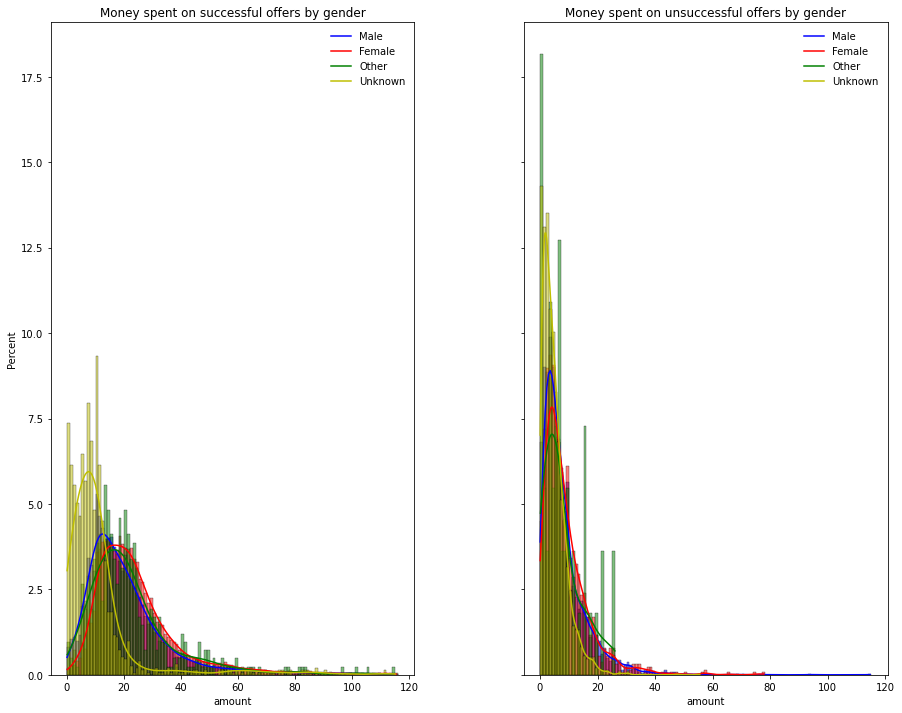

In [204]:
plt.subplots(1, 2, sharey=True, figsize=(15, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.subplot(121)
sns.histplot(unencodedSuccessful[(unencodedSuccessful.gender == 'M') & (unencodedSuccessful.amount)].amount, color="b", kde=True, stat="percent", binwidth=1)
sns.histplot(unencodedSuccessful[(unencodedSuccessful.gender == 'F') & (unencodedSuccessful.amount)].amount, color="r", kde=True, stat="percent", binwidth=1)
sns.histplot(unencodedSuccessful[(unencodedSuccessful.gender == 'O') & (unencodedSuccessful.amount)].amount, color="g", kde=True, stat="percent", binwidth=1)
sns.histplot(unencodedSuccessful[(unencodedSuccessful.gender == 'U') & (unencodedSuccessful.amount)].amount, color="y", kde=True, stat="percent", binwidth=1)
plt.title('Money spent on successful offers by gender')
#plt.gca().get_yaxis().set_visible(False)
plt.legend(['Male','Female', 'Other', 'Unknown'], frameon=False)

plt.subplot(122)
sns.histplot(unencodedUnsuccessful[(unencodedUnsuccessful.gender == 'M') & (unencodedUnsuccessful.amount)].amount, color="b", kde=True, stat="percent", binwidth=1)
sns.histplot(unencodedUnsuccessful[(unencodedUnsuccessful.gender == 'F') & (unencodedUnsuccessful.amount)].amount, color="r", kde=True, stat="percent", binwidth=1)
sns.histplot(unencodedUnsuccessful[(unencodedUnsuccessful.gender == 'O') & (unencodedUnsuccessful.amount)].amount, color="g", kde=True, stat="percent", binwidth=1)
sns.histplot(unencodedUnsuccessful[(unencodedUnsuccessful.gender == 'U') & (unencodedUnsuccessful.amount)].amount, color="y", kde=True, stat="percent", binwidth=1)
plt.title('Money spent on unsuccessful offers by gender')
#plt.gca().get_yaxis().set_visible(False)
plt.legend(['Male','Female', 'Other', 'Unknown'], frameon=False)

- As should be expected, successful offers entice people to spend more overall
- The population for people that refuse to fill in their data behaves wildly differently from other genders, spending less but more frequently. If Starbucks could successfully tap into this demographic with fitting offers to get them to spend more, this could be a huge win.
- Males seem to complete more offers while spending slightly less, but the difference is hardly significant.
- People who filled in 'Other' for their gender do spend less money and less often when not influenced by offers though, so the trick here would be to get them to view their offers more reliably.

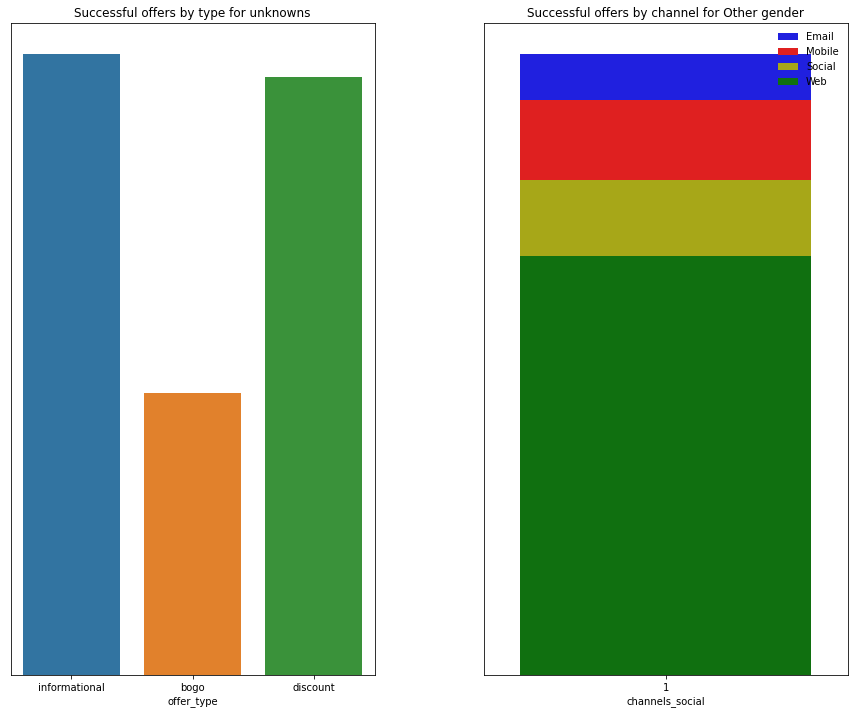

In [205]:
plt.subplots(1, 2, sharey=False, figsize=(15, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.subplot(121)
sns.countplot(data=unencodedSuccessful[(unencodedSuccessful.gender == 'U') & (unencodedSuccessful.amount > 0)], x='offer_type')
plt.title('Successful offers by type for unknowns')
plt.gca().get_yaxis().set_visible(False)

plt.subplot(122)
sns.countplot(data=unencodedSuccessful[(unencodedSuccessful.gender == 'O') & (unencodedSuccessful.amount > 0) & (unencodedSuccessful.channels_email == 1)], color="b", x='channels_email')
sns.countplot(data=unencodedSuccessful[(unencodedSuccessful.gender == 'O') & (unencodedSuccessful.amount > 0) & (unencodedSuccessful.channels_mobile == 1)], color="r", x='channels_mobile')
sns.countplot(data=unencodedSuccessful[(unencodedSuccessful.gender == 'O') & (unencodedSuccessful.amount > 0) & (unencodedSuccessful.channels_web == 1)], color="y", x='channels_web')
sns.countplot(data=unencodedSuccessful[(unencodedSuccessful.gender == 'O') & (unencodedSuccessful.amount > 0) & (unencodedSuccessful.channels_social == 1)], color="g", x='channels_social')
plt.title('Successful offers by channel for Other gender')
plt.gca().get_yaxis().set_visible(False)
plt.legend(['Email','Mobile', 'Social', 'Web'], frameon=False)

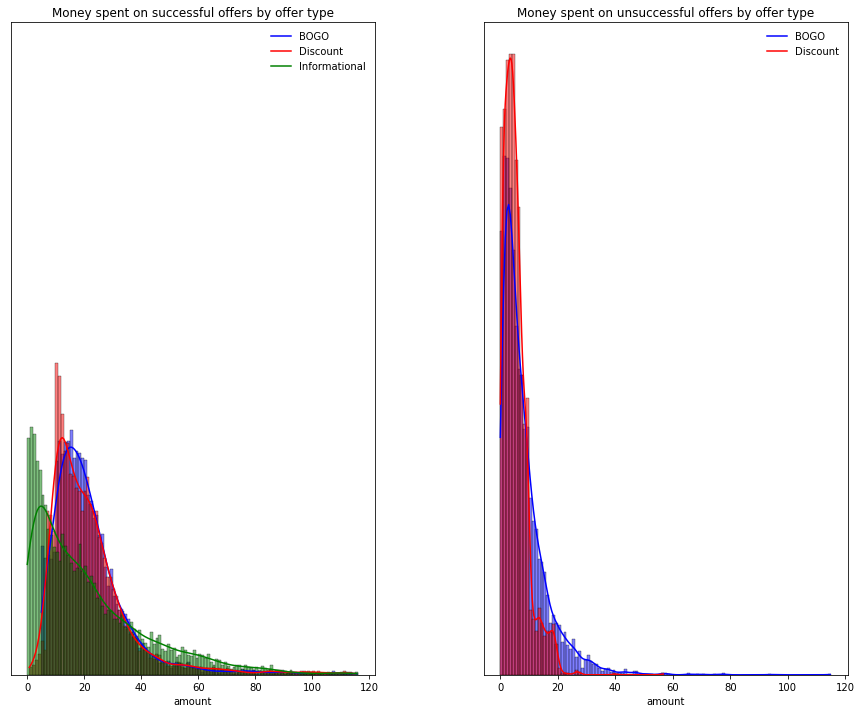

In [206]:
plt.subplots(1, 2, sharey=True, figsize=(15, 12))
plt.subplots_adjust(hspace=0.3, wspace=0.3)

plt.subplot(121)
sns.histplot(unencodedSuccessful[(unencodedSuccessful.offer_type_bogo == 1) & (unencodedSuccessful.amount > 0)].amount, color="b", kde=True, stat="density", binwidth=1)
sns.histplot(unencodedSuccessful[(unencodedSuccessful.offer_type_discount == 1) & (unencodedSuccessful.amount > 0)].amount, color="r", kde=True, stat="density", binwidth=1)
sns.histplot(unencodedSuccessful[(unencodedSuccessful.offer_type_informational == 1) & (unencodedSuccessful.amount > 0)].amount, color="g", kde=True, stat="density", binwidth=1)
plt.title('Money spent on successful offers by offer type')
plt.gca().get_yaxis().set_visible(False)
plt.legend(['BOGO','Discount', 'Informational'],frameon=False)

plt.subplot(122)
sns.histplot(unencodedUnsuccessful[(unencodedUnsuccessful.offer_type_bogo == 1) & (unencodedUnsuccessful.amount > 0)].amount, color="b", kde=True, stat="density", binwidth=1)
sns.histplot(unencodedUnsuccessful[(unencodedUnsuccessful.offer_type_discount == 1) & (unencodedUnsuccessful.amount > 0)].amount, color="r", kde=True, stat="density", binwidth=1)
sns.histplot(unencodedUnsuccessful[(unencodedUnsuccessful.offer_type_informational == 1) & (unencodedUnsuccessful.amount > 0)].amount, color="g", kde=True, stat="density", binwidth=1)
plt.title('Money spent on unsuccessful offers by offer type')
plt.gca().get_yaxis().set_visible(False)
plt.legend(['BOGO','Discount'],frameon=False)

- As might be expected, informationals don't incite as much spending as other offer types.
- BOGO offers get people to spend slightly more, while discounts get used slightly more. Both are hardly significant though, so the effect should be found in differences in demographies.